# How deep are financial models?
<div style="text-align: right">(C) Nikolai Nowaczyk, Jörg Kienitz, Sarp Kaya Acar, Qian Liang 2019-2020</div>

In this notebook, we apply deep learning techniques to financial derivative pricing models, namely the Black-Scholes model and the Heston model. But just how deep does a neural network have to be to adaequately capture the pricing function? We employ a [systematic technique to determine a good network topology](https://github.com/niknow/machine-learning-examples/blob/master/network_topology_selection/network_topology_selection.ipynb) and inspect the results. We find that both, the Black-Scholes and the Heston pricing function can be learned quite easily by a standard multilayer perceptron (MLP).

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras
import os
from ipywidgets import interact
import ipywidgets as wg
import json
import pickle
import unittest

from keras_grid import MLPGrid, LSTMGrid
from pricinglib import BlackScholesCallPrice, HestonCallPrice

%matplotlib notebook

In [3]:
data_folder = os.path.join(os.getcwd(), 'data')
picture_folder = 'pics'

export_figures = True
def export_figure(fig, filename, extension='.pdf', **kwargs):
    if export_figures:
        fig.savefig(os.path.join(os.path.join(os.getcwd(), picture_folder), filename + extension), **kwargs)

# Models

## Black-Scholes Model

Let $(\Omega, \mathcal{F}, \mathbb{Q})$ be a probability space (where we think of $\mathbb{Q}$ as the risk-neutral measure). Then the Black-Scholes model assumes the following stochastic dynamics for the stock:
\begin{align}
dS_t = r S_t dt + \sigma S_t dW_t, \qquad S_0 = s_0
\end{align}
where
* $s_0$ is the initial value for the stock
* $r \in \mathbb{R}$ is a fixed *risk-free rate*, 
* $\sigma > 0$ is the *volatility*, 
and the process $W_t$ is a Brownian motion. 

In the Black-Scholes model, a European call option $C = C(T,K)$ with maturity $T>0$ and strike $K>0$ has market value 
\begin{align}
    C_t = \mathbb{E}_t[(S_T - K)^+] = S_t \Phi(d_1) - K \exp(-r (T-t)) \Phi(d_2),
\end{align}
where $\Phi$ denotes the cdf of the standard normal distribution and 
$$ d_1 := \frac{1}{\sqrt{T-t}} \Big( \log\Big( \frac{S_t}{K} \Big) + (r + \frac{\sigma^2}{2}) (t-T) \Big), \quad
d_2 := d_1 - \sigma \sqrt{T-t}$$

## Heston Model
The Heston model assumes the following stochastic dynamics:
\begin{align}
    dS_t &= rS_t dt + \sqrt{V_t}dW_t, \quad S_0 = s_0 \\
    dV_t &= \kappa(\theta - V_t) S_t dt + \xi \sqrt{V_t} dZ_t, && V_0 = v_0,
\end{align}
where
* $s_0$ is the initial value for the stock,
* $v_0$ is the initial value for the volatility,
* $r$ is the risk-free rate,
* $\kappa$ is the mean reversion rate of the volatility,
* $\xi$ is the volatility of the volatility
* $\rho$ is the assumed correlation between the Brownian motions $W_t$ and $Z_t$.

One typically assumes that the parameters are chosen such that the Feller condition holds: $2 \kappa \theta > \xi^2$.

The option price in a Heston model can be computed (for $t=0$) via 
\begin{align}
    C_0(T,K) = S_0 \Pi_1 - e^{-rT} K \Pi_2,
\end{align}
where $\Pi_1$ and $\Pi_2$ are given as integrals over the characteristic function $\Psi = \Psi_{\ln(S_T)}$ of $\ln(S_T)$:
\begin{align}
    \Pi_1 &= \frac{1}{2} + \frac{1}{\pi}\int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w-i)}{i w \Psi(-i)} \Big) dw} \\
    \Pi_2 &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w)}{i w } \Big) dw}
\end{align}

# Generating the data set

When generating a training set for any neural network that learns a derivative pricing function of any financial model, one always has two choices:

* **Option A:** First generate realizations of the underlying and then price the derivative.
* **Option B:** Generate derivative prices directly using synthetic values of the underlying.

Option A has the advantage that the distribution of the derivative prices is more concentrated around realistic values. This means that the network will have more data to learn the derivative prices for typical values of the underlying, but less data for corner cases. Option B has the advantage that one can simply chose the ranges irrespective on how they might be distributed according to the underyling stochastic dynamics. 

For the Black-Scholes model, if we only consider $t=0$ pricing, it does not matter, which option we chose as the option prices only depend linearly on $S_0$. Thus, in the following, we consider $t=0$ pricing.

In [4]:
# parameter configuration
S0=100
T_max=1
maturity_grid = np.linspace(1/300, T_max, 300)
strike_grid = np.linspace(S0*0.8, S0*1.2, 400)
maturity_grid_, strike_grid_ = np.meshgrid(maturity_grid, strike_grid)
maturity_grid_ = maturity_grid_.ravel()
strike_grid_ = strike_grid_.ravel()

# heston model
v0 = 0.02
vLong = 0.04
kappa = 0.3
volvol = 0.4
rho = -0.6
q=0

# black scholes model
S = 100  # spot price
r = 0.03  # risk-free rate
sigma = np.sqrt(v0) # volatility

In [ ]:
# generation of the data set
df = pd.DataFrame({'K': strike_grid_,
                   'T': maturity_grid_,
                   'C_BlackScholes': BlackScholesCallPrice(S0, r, sigma, maturity_grid_, strike_grid_, t=0)})
df['C_Heston'] = df.apply(lambda row: HestonCallPrice(S0, row['T'], row['K'], r, q, v0, vLong, kappa, sigma, rho), axis=1)

In [91]:
df.to_pickle(os.path.join(data_folder, 'df_prices.pkl')) # save dataset to file

In [5]:
df = pd.read_pickle(os.path.join(data_folder, 'df_prices.pkl')) # load dataset from file

## Visualizing the data set

<IPython.core.display.Javascript object>


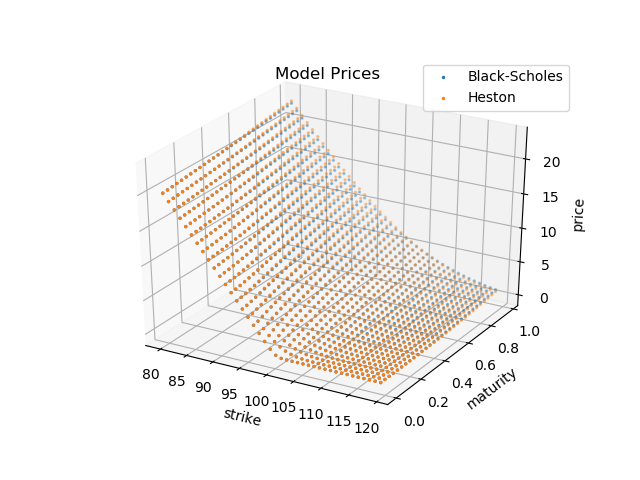

interactive(children=(SelectMultiple(description='Models', index=(0, 1), options=('BlackScholes', 'Heston'), v…

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# thinning out the df to avoid performance issues in the plot
df_3dplot = df[(df['T'].isin(maturity_grid[::10])) & (df['K'].isin(strike_grid[::10]))]


@interact(models=wg.SelectMultiple(
    options=['BlackScholes', 'Heston'],
    value=['BlackScholes', 'Heston'],
    description='Models',
))
def plot_dataset(models):
    ax.clear()
    if 'BlackScholes' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_BlackScholes'], s=2, label='Black-Scholes')
    if 'Heston' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_Heston'], s=2, label='Heston')
    ax.legend()
    ax.set_xlabel('strike')
    ax.set_ylabel('maturity')
    ax.set_zlabel('price')
    ax.set_title('Model Prices')
    export_figure(fig, 'model_prices_' + '_'.join(models))

We conclude that while the equations of the stochastic dynamics differ between the Black-Scholes and the Heston model, the resulting training sets are quite similar when viewed as data sets. However, the plot below also clearly shows the differences in option prices. One should remark that these differences of course depen on the parameters chosen for the Black-Scholes and the Heston model.

<IPython.core.display.Javascript object>


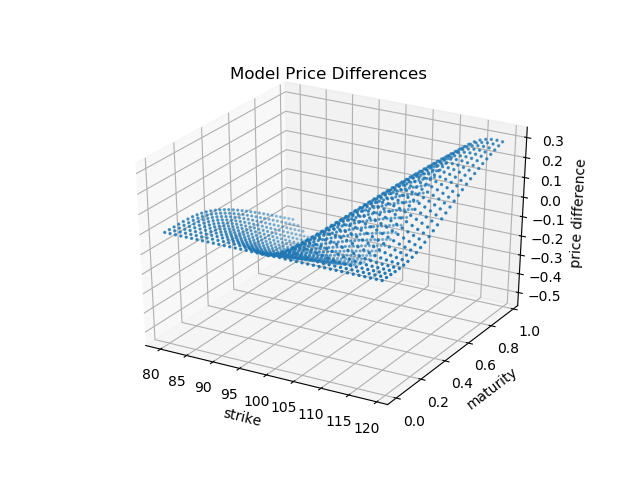

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_BlackScholes']- df_3dplot['C_Heston'], s=2, label='Black-Scholes')
ax.set_xlabel('strike')
ax.set_ylabel('maturity')
ax.set_zlabel('price difference')
ax.set_title('Model Price Differences')
export_figure(fig, 'model_price_diffs')

# Network Topology Selection

We define a 2D grid of Multilayer Perceptrons (MLPs) as candidate networks to learn the Black-Scholes and Heston pricing formula. The first dimension is the number of neurons in each layer, whereas the second dimension is the number of layers. When increasing the number of layers, we chose to decrease the number of neurons such that the resulting number of weights stays roughly constant. The rationale behind this is that we want to find a good network topology given a number of degrees of freedom. More details on this reasoning can be found [here](https://github.com/niknow/machine-learning-examples/blob/master/network_topology_selection/network_topology_selection.ipynb).
We also set up a comparable grid of LSTM networks and compare which of the two topologies is more suitable to learn the pricing function.

## Setting up the candidate models

In [18]:
pricing_models = ['BlackScholes', 'Heston']
pricing_model = pricing_models[0]  # change to 1 for Heston

In [19]:
# setup MLPs
n_o = 1
n_i = 2
range_units = np.array([2**i for i in range(6, 12)])
range_layers = np.array(list(range(2,6)))

mlpg = MLPGrid(num_inputs=n_i,
               num_outputs=n_o,
               range_units=range_units,
               range_layers=range_layers,
               constant_num_weights=True)
mlpg.initialize()

# setup LSTMs such that number of weights is comparable
range_units = np.array([LSTMGrid.num_units(n_i-1, n_o, n_L=range_layers[0], 
                                           n_w=MLPGrid.num_weights(n_i, n_o, n_L=range_layers[0], 
                                                                   n_u=mlpg.range_units[unit_idx]))
                       for unit_idx in range(len(mlpg.range_units))])

lstmg = LSTMGrid(num_inputs=n_i-1, 
                num_outputs=n_o, 
                range_units=range_units,
                range_layers=range_layers,
                num_time_steps=maturity_grid.shape[0],
                constant_num_weights=True)
lstmg.initialize()

<IPython.core.display.Javascript object>


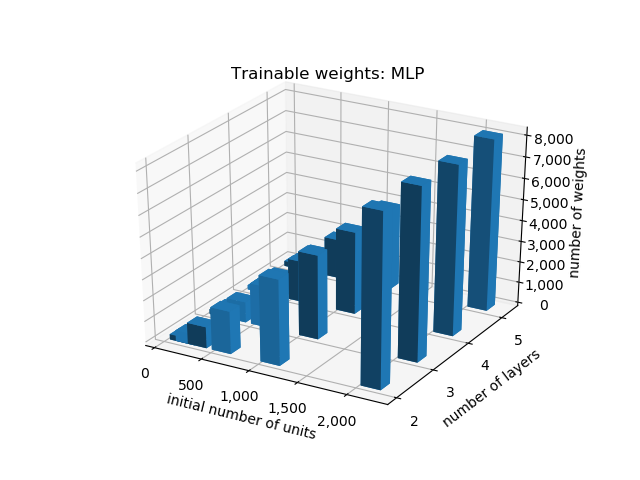

interactive(children=(RadioButtons(description='Network Type:', options=('MLP', 'LSTM'), value='MLP'), Output(…

In [20]:
# plot number of weights
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

@interact(network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'))
def plot_num_weights(network_type):
    if network_type=='MLP':
        mgrid=mlpg
        xx, yy = np.meshgrid(mlpg.range_units, mlpg.range_layers)
        width = 200
    else:
        mgrid=lstmg
        xx, yy = np.meshgrid(lstmg.range_units, lstmg.range_layers)
        width = 3
    x, y = xx.ravel(), yy.ravel()
    z = np.array([[mgrid.models[u][l].count_params() for u in range(len(range_units))] for l in range(len(range_layers))]).ravel()
    bottom = np.zeros_like(z)    
    depth = 0.25
    ax.clear()
    ax.bar3d(x, y, bottom, width, depth, z, shade=True)
    ax.set_title('Trainable weights: %s' % network_type)
    ax.set_xlabel('initial number of units')
    ax.set_ylabel('number of layers')
    ax.set_zlabel('number of weights')
    ax.set_yticks(range_layers)
    ax.zaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x))))
    export_figure(fig, 'trainable_weights_' + network_type)

When comparing the number of units between MLP and LSTM, we find that the number of units in the LSTM that generates the same number of weights than the MLP is quite low. That is because a layer in an LSTM has much more complexity than in an MLP, recall the introduction to LSTMs [here](https://nbviewer.jupyter.org/github/niknow/machine-learning-examples/blob/master/lstm_intro/lstm_intro.ipynb). This means that we would expect the LSTM to perform better in situations where this additional complexity is needed to solve the problem the network is trying to learn and to perform worse in cases where it is not needed, because then the MLP has much more units available per layer.

## Training the networks

In [21]:
compile_params = {
    'loss': 'mean_squared_error',
    'metrics': ['mean_squared_error', 'mean_absolute_error'],
    'optimizer': 'Adam',
}
mlpg.compile(**compile_params)
lstmg.compile(**compile_params)

In [22]:
fit_params={
    'validation_split': 0.2,
    'epochs': 50,
    'shuffle': True}

In [ ]:
%time
mlpg.fit(x=df[['K', 'T']], y=df['C_'+pricing_model],**fit_params)
print("Training complete.")

In [116]:
mlpg.save(os.path.join(data_folder, '_'.join([pricing_model, 'MLP'])))

In [33]:
data_lstm = {pricing_model: df[['K', 'C_'+pricing_model]].values.reshape(strike_grid.shape[0], int(df[['K', 'C_'+pricing_model]].shape[0]/strike_grid.shape[0]), 2)
            for pricing_model in pricing_models}

In [ ]:
%time
lstmg.fit(x=data_lstm[pricing_model][:, :, 0][:, :, np.newaxis], y=data_lstm[pricing_model][:, :, 1][:, :, np.newaxis], **fit_params)
print("Training complete")

In [119]:
lstmg.save(os.path.join(data_folder, '_'.join([pricing_model, 'LSTM'])))

## Loading the results

In [ ]:
%time
model_grids = {pricing_model:{'MLP': MLPGrid.from_disk(os.path.join(data_folder, '_'.join([pricing_model, 'MLP']))),
                              'LSTM': LSTMGrid.from_disk(os.path.join(data_folder, '_'.join([pricing_model, 'LSTM'])))}
              for pricing_model in pricing_models}

## Inspecting the grid of results

<IPython.core.display.Javascript object>


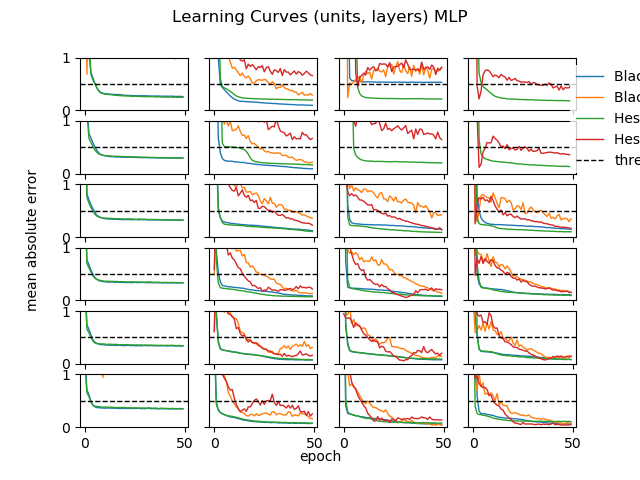

interactive(children=(RadioButtons(description='Network Type:', options=('MLP', 'LSTM'), value='MLP'), Output(…

In [26]:
num_unit_ranges = len(range_units)
num_layer_ranges = len(range_layers)

fig, axes = plt.subplots(nrows=num_unit_ranges, ncols=num_layer_ranges, sharex=True, sharey=True)

@interact(network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'))
def plot_learning_curves(network_type):
    fig.suptitle('Learning Curves (units, layers) %s' % network_type)
    lwidth=1
    for u in range(num_unit_ranges):
        for l in range(num_layer_ranges):
            axes[u][l].clear()
            axes[u][l].plot(model_grids[pricing_models[0]][network_type].history[u][l]['mean_absolute_error'], lw=lwidth, label='Black-Scholes bias')
            axes[u][l].plot(model_grids[pricing_models[0]][network_type].history[u][l]['val_mean_absolute_error'], lw=lwidth, label='Black-Scholes variance')
            axes[u][l].plot(model_grids[pricing_models[1]][network_type].history[u][l]['mean_absolute_error'], lw=lwidth, label='Heston bias')
            axes[u][l].plot(model_grids[pricing_models[1]][network_type].history[u][l]['val_mean_absolute_error'], lw=lwidth, label='Heston variance')       
            axes[u][l].set_ylim([0, 1])
            axes[u][l].axhline(0.5, color='k', linestyle='--', lw=lwidth, label='threshold')
    handles, labels = axes[0][0].get_legend_handles_labels()
    leg = fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.23, 0.88))
    leg.get_frame().set_linewidth(0.0)
    fig.text(0.5, 0.04, 'epoch', ha='center')
    fig.text(0.04, 0.5, 'mean absolute error', va='center', rotation='vertical')
    export_figure(fig, 'learning_curves_%s' %  network_type, bbox_inches='tight')

## Selecting & Inspecting the Final Candidates
Based on the above reasoning, we chose the final candiates.

In [27]:
model = {'BlackScholes': {
            'MLP': model_grids['BlackScholes']['MLP'][2][1],
            'LSTM': model_grids['BlackScholes']['LSTM'][5][1]},
        'Heston': {
            'MLP': model_grids['Heston']['MLP'][2][1],
            'LSTM': model_grids['Heston']['LSTM'][5][1]},         
        }

## Statistics
We evaluate the chosen models in a few standard metrics.

In [28]:
model['BlackScholes']['MLP'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 29)                87        
_________________________________________________________________
dense_140 (Dense)            (None, 29)                870       
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 30        
Total params: 987
Trainable params: 987
Non-trainable params: 0
_________________________________________________________________


In [29]:
model['BlackScholes']['LSTM'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_112 (LSTM)              (None, 300, 25)           2700      
_________________________________________________________________
lstm_113 (LSTM)              (None, 300, 25)           5100      
_________________________________________________________________
dense_214 (Dense)            (None, 300, 1)            26        
Total params: 7,826
Trainable params: 7,826
Non-trainable params: 0
_________________________________________________________________


In [30]:
# traning samples per parameters
df.shape[0] / model['BlackScholes']['MLP'].count_params(), df.shape[0] / model['BlackScholes']['LSTM'].count_params()

(121.580547112462, 15.333503705596728)

In [31]:
model['BlackScholes']['MLP'].evaluate(df[['K', 'T']], df['C_BlackScholes'])

120000/120000 [==============================] - ETA:  - 21s 175us/step


[0.0902163147990735, 0.0902163147990735, 0.22852515545263885]

In [34]:
model['BlackScholes']['LSTM'].evaluate(data_lstm['BlackScholes'][:, :, 0][:, :, np.newaxis], data_lstm['BlackScholes'][:, :, 1][:, :, np.newaxis])

400/400 [==============================] - 5s 13ms/step


[4.193905065059662, 4.1939046096801755, 1.2034054327011108]

## Predictions
We compare the quality of predictions made by the trained model.

<IPython.core.display.Javascript object>


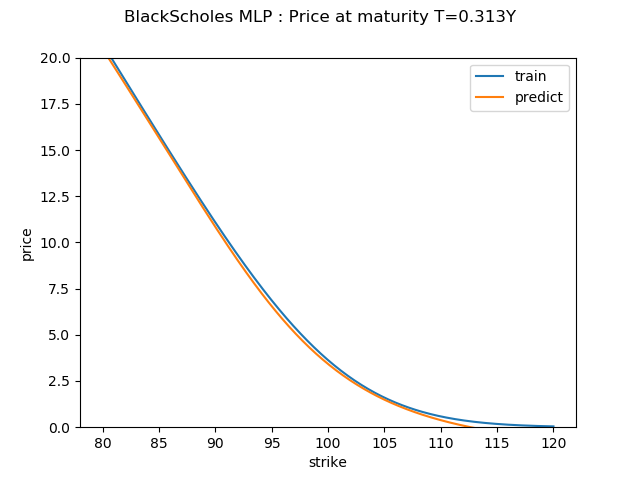

interactive(children=(RadioButtons(description='Pricing Model:', options=('BlackScholes', 'Heston'), value='Bl…

In [37]:
lstmx = {pricing_model: data_lstm[pricing_model][:, :, 0][:, :, np.newaxis] for pricing_model in pricing_models}
lstmy = {pricing_model: data_lstm[pricing_model][:, :, 1][:, :, np.newaxis] for pricing_model in pricing_models}
lstmpred = {pricing_model: model[pricing_model]['LSTM'].predict(lstmx[pricing_model]) for pricing_model in pricing_models}

fig, ax = plt.subplots()

@interact(pricing_model=wg.RadioButtons(options=pricing_models,
                                       value='BlackScholes',
                                       description='Pricing Model:'),
          network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'),
          matindex=wg.IntSlider(min=0, max=maturity_grid.shape[0]-1, value=0),)
def plot_slice(pricing_model, network_type, matindex):
    fig.suptitle(pricing_model + ' ' + network_type + ' ' + ': Price at maturity T={0:.3f}Y'.format(maturity_grid[matindex]))
    ax.clear()
    if network_type=='MLP':
        df_slice = df[df['T']==maturity_grid[matindex]]
        ax.plot(df_slice['K'], df_slice['C_'+pricing_model], label='train')
        ax.plot(df_slice['K'], model[pricing_model]['MLP'].predict(df_slice[['K', 'T']]), label='predict')
    else:
        ax.plot(lstmx[pricing_model][:, matindex, :], lstmy[pricing_model][:, matindex, :], label='train')
        ax.plot(lstmx[pricing_model][:, matindex, :], lstmpred[pricing_model][:, matindex, :], label='predict')
    ax.set_xlabel('strike')
    ax.set_ylabel('price')
    ax.legend()
    ax.set_ylim([0,20])
    export_figure(fig, 'predictions_%s_%s' % (pricing_model, network_type) )

In line with the learning curves, we find that the MLP fits the data better than the LSTM.

<IPython.core.display.Javascript object>


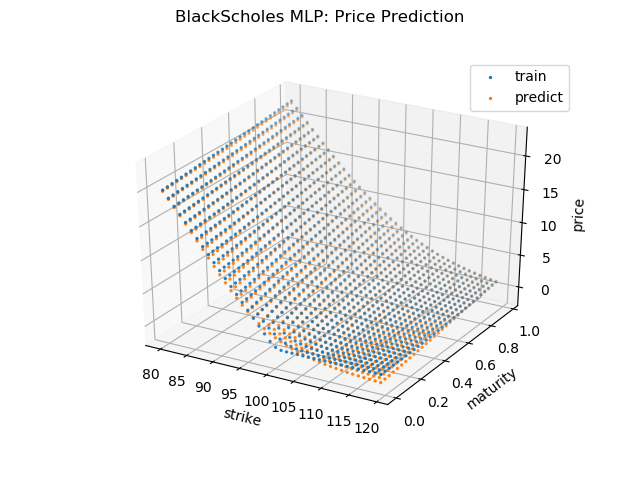

interactive(children=(RadioButtons(description='Pricing Model:', options=('BlackScholes', 'Heston'), value='Bl…

In [38]:
# 3D view of predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# thinning out the df to avoid performance issues in the plot
df_3dplot = df[(df['T'].isin(maturity_grid[::10])) & (df['K'].isin(strike_grid[::10]))]

@interact(pricing_model=wg.RadioButtons(options=pricing_models,
                                       value='BlackScholes',
                                       description='Pricing Model:'),
          network_type=wg.RadioButtons(options=['MLP', 'LSTM'],
                                       value='MLP',
                                       description='Network Type:'))
def plot_3d_predictions(pricing_model, network_type):
    fig.suptitle(pricing_model + ' ' + network_type + ': Price Prediction')
    ax.clear()
    if network_type=='MLP':
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_'+pricing_model], s=2, label='train')
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], model[pricing_model]['MLP'].predict(df_3dplot[['K', 'T']]), s=2, label='predict')
    else:
        ax.scatter3D(lstmx[pricing_model][::10, ::10, :], df_3dplot['T'], lstmy[pricing_model][::10, ::10, :], s=2, label='train')
        ax.scatter3D(lstmx[pricing_model][::10, ::10, :], df_3dplot['T'], lstmpred[pricing_model][::10, ::10, :], s=2, label='predict')        
    ax.legend()
    ax.set_xlabel('strike')
    ax.set_ylabel('maturity')
    ax.set_zlabel('price')
    export_figure(fig, 'predictions_3d_%s_%s' % (pricing_model, network_type) )
    plt.show()

# Conclusion

* The overall champion model to learn the Black-Scholes (or Heston) pricing formula is the MLP with $n_L=3$ layers and $n_u=13$ units (equivalent to $64$ initial number of units). 
* The performance of the champion MLP on the Black-Scholes model and the Heston model is comparable.
* The LSTM is not a good network topology choice for learning the pricing formula of either of the two models.
* The performance of the networks is much worse on the boundary than it is in the interior of the data set. An easy way out of this is to choose the training set slightly bigger than needed in practice.